# Store Sales - Time Series Forecasting

### Equipo
#### Diego Díaz Ayala
A01770236
#### Carlos Ortega Clement
A01707480
#### Eduardo González Luna
A01658281
#### Jesús Miranda Faustino
A01769232
#### Hilda Beltrán Acosta
A01251916

## Extract data

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

from statsmodels.graphics.tsaplots import plot_pacf
from sklearn import metrics
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import joblib
import pickle

Importación de bibliotecas: Se han importado varias bibliotecas necesarias para el análisis de series temporales y la creación de modelos de pronóstico. Esto incluye bibliotecas como pandas, matplotlib, numpy, seaborn, plotly, sklearn, statsmodels, joblib, y pickle. Estas bibliotecas proporcionarán herramientas para la manipulación de datos, visualización y modelado.

In [2]:
DIR = Path('../input/store-sales-time-series-forecasting')

## Creando un DataFrame

In [3]:
# Create a DataFrame from each dataset
df_traind = pd.read_csv(DIR / 'train.csv',parse_dates=['date'])
df_train = pd.read_csv(DIR / 'train.csv')
df_test = pd.read_csv(DIR / 'test.csv')
df_oil = pd.read_csv(DIR / 'oil.csv')
df_holiday = pd.read_csv(DIR / 'holidays_events.csv')
holidays_events = pd.read_csv(DIR / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },parse_dates=['date'],infer_datetime_format=True)
holidays_events = holidays_events.set_index('date').to_period('D')
df_stores = pd.read_csv(DIR / 'stores.csv')
df_transactions = pd.read_csv(DIR / 'transactions.csv')

**Cargando DataFrames:**

Creamos un DataFrame llamado df_traind al cargar el conjunto de datos 'train.csv' con la opción para analizar las fechas ('parse_dates') en la columna 'date', retornado  objetos de fecha y hora en formato 'aaaa-mm-dd',  Esto nos permite trabajar con las fechas de manera eficiente.


 Se han cargado varios otros conjuntos de datos, como 'train.csv', 'test.csv', 'oil.csv', 'holidays_events.csv', 'stores.csv', y 'transactions.csv'. Cada uno de estos conjuntos de datos contiene información relevante para el pronóstico de ventas y se almacenará en DataFrames separados para su posterior análisis.

En holidays_events, se realiza un preprocesamiento adicional en el conjunto de datos 'holidays_events.csv'. Se han especificado los tipos de datos de algunas columnas: 'type', 'locale', 'locale_name', 'description' se volcieron tipo categorico, mientras que 'transferred'se hace boolena, tambien se ha convertido la columna 'date' en un índice de tipo período ('to_period'). Esto ayuda en el análisis de las festividades y eventos relacionados con las ventas.

**Nuestrasa variables conteneran lo siguiente:**


  - df_holiday: Contiene información sobre festividades y eventos.
  - df_oil: Contiene datos diarios sobre los precios del petróleo.
  - df_stores: Proporciona metadatos sobre las tiendas.
  - df_test: Conjunto de datos de prueba.
  - df_train: Conjunto de datos de entrenamiento.
  - df_transactions: Contiene información sobre las transacciones



## Evaluar posibles métodos de imputación para gestionar valores faltantes (NaN)

    La primera opción a evaluar es eliminar las filas con valores faltantes.

    La segunda opción es interpolar los datos con un método lineal.

    La tercera opción es evaluar la distribución de los valores para decidir si la mejor opción es llenar los valores con los datos promedio o los datos medianos.

Obtener la transformación logarítmica de la columna "dcoilwtico" (precio del petróleo) para observar cambios porcentuales, también ayuda a reducir la varianza, lo que facilita el análisis. Otra razón para aplicar la transformación logarítmica es linealizar las relaciones, lo cual se prefiere al realizar análisis, ya que ayuda a reducir el impacto de los datos atípicos en el modelo de regresión.


In [4]:
# Look for NaN values in the DataFrames
henan = df_holiday.isna().sum().sum()
oilnan = df_oil.isna().sum().sum()
storesnan = df_stores.isna().sum().sum()
testnan = df_test.isna().sum().sum()
trainnan = df_train.isna().sum().sum()
transnan = df_transactions.isna().sum().sum()

print('NaN train:', trainnan)
print('NaN test:', testnan)
print('NaN oil:', oilnan)
print('NaN holidays events:', henan)
print('NaN stores:', storesnan)
print('NaN transactions:', transnan)

NaN train: 0
NaN test: 0
NaN oil: 43
NaN holidays events: 0
NaN stores: 0
NaN transactions: 0


Lo primero que realizamos para limpiar nuestros datos es buscar valores Nan

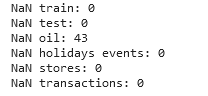

Este paso es importante para identificar y comprender la cantidad de datos faltantes en los conjuntos de datos, lo que puede ser crucial para tomar decisiones sobre cómo manejar esos valores faltantes en el proceso de análisis y modelado de datos

### Combina el conjunto de datos de petróleo (oil) y el conjunto de datos de entrenamiento (train), ya que queremos determinar si existe una relación entre el precio del petróleo y las ventas por día.

In [5]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

df_final = pd.merge(df_train, df_oil, on = 'date')
df_final

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
2143741,3000883,2017-08-15,9,POULTRY,438.133,0,47.57
2143742,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57
2143743,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57
2143744,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57


El objetivo de esta fusión es analizar si existe una relación entre el precio del petróleo y las ventas diarias. Aquí está una explicación de lo que se ha hecho.

df_final: Este DataFrame contendrá todas las columnas de los conjuntos de datos originales, así como la información combinada de ambos. Esto permitirá analizar la relación entre las ventas diarias y el precio del petróleo.

## Evaluar posibles métodos de imputación para gestionar valores faltantes (NaN)

    La primera opción a evaluar es eliminar las filas con valores faltantes.

    La segunda opción es interpolar los datos con un método lineal.

    La tercera opción es evaluar la distribución de los valores para decidir si la mejor opción es llenar los valores con los datos promedio o los datos medianos.

Obtener la transformación logarítmica de la columna "dcoilwtico" (precio del petróleo) para observar cambios porcentuales, también ayuda a reducir la varianza, lo que facilita el análisis. Otra razón para aplicar la transformación logarítmica es linealizar las relaciones, lo cual se prefiere al realizar análisis, ya que ayuda a reducir el impacto de los datos atípicos en el modelo de regresión.


In [6]:
# Since there are 43 NaN values in df_oil, we'll analyze which Data Imputation method works best for this case
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_final.describe()

,id,date,store_nbr,sales,onpromotion,dcoilwtico
count,2143746.000,2143746,2143746.000,2143746.000,2143746.000,2072466.000
mean,1500528.675,2015-04-24 09:35:45.635909888,27.500,321.629,2.831,67.926
min,0.000,2013-01-01 00:00:00,1.000,0.000,0.000,26.190
25%,749776.250,2014-02-26 00:00:00,14.000,0.000,0.000,46.380
50%,1499552.500,2015-04-24 00:00:00,27.500,10.000,0.000,53.330
75%,2252892.750,2016-06-21 00:00:00,41.000,180.000,0.000,95.800
max,3000887.000,2017-08-15 00:00:00,54.000,124717.000,741.000,110.620
std,866809.911,NaN,15.586,970.755,13.243,25.666


Despues de hacer el merge describimos los datos.

In [7]:
oil_mean = df_final.copy()

In [8]:
oil_mean.dcoilwtico.fillna(df_oil['dcoilwtico'].mean(), inplace = True)
oil_mean.describe()

,id,date,store_nbr,sales,onpromotion,dcoilwtico
count,2143746.000,2143746,2143746.000,2143746.000,2143746.000,2143746.000
mean,1500528.675,2015-04-24 09:35:45.635909888,27.500,321.629,2.831,67.919
min,0.000,2013-01-01 00:00:00,1.000,0.000,0.000,26.190
25%,749776.250,2014-02-26 00:00:00,14.000,0.000,0.000,46.670
50%,1499552.500,2015-04-24 00:00:00,27.500,10.000,0.000,54.010
75%,2252892.750,2016-06-21 00:00:00,41.000,180.000,0.000,95.490
max,3000887.000,2017-08-15 00:00:00,54.000,124717.000,741.000,110.620
std,866809.911,NaN,15.586,970.755,13.243,25.236


Realizando un tratamiento para manejar los valores faltantes (NaN) en la columna 'dcoilwtico' (precio del petróleo) del DataFrame df_final. Aplicamos un describe, para comprender los datos.

Después de imputar la media en lugar de eliminar las filas con valores faltantes en la columna dcoilwtico, las estadísticas descriptivas muestran que los valores no nulos de dcoilwtico han aumentando y la desviación estándar ha disminuido, así vemos que este tratamiento ha afectando la distribución estandar de los datos del precio del petróleo.

### Modify data types for id, store_nbr, and onpromotion

This is to unify the data type between all variables to find possible relationships between them, it's possible we won't be using all of them.

In [9]:
df_final = oil_mean
df_final

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,67.714
1,1,2013-01-01,1,BABY CARE,0.000,0,67.714
2,2,2013-01-01,1,BEAUTY,0.000,0,67.714
3,3,2013-01-01,1,BEVERAGES,0.000,0,67.714
4,4,2013-01-01,1,BOOKS,0.000,0,67.714
...,...,...,...,...,...,...,...
2143741,3000883,2017-08-15,9,POULTRY,438.133,0,47.570
2143742,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.570
2143743,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.570
2143744,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.570


Esto significa que 'df_final' ahora contendrá los cambios realizados en las modificaciones anteriores, incluyendo la imputación de valores faltantes en 'dcoilwtico'.

In [10]:
df_final.id = df_final.id.astype('float64')
df_final.store_nbr = df_final.store_nbr.astype('float64')
df_final.onpromotion = df_final.onpromotion.astype('float64')

Change date column to datetime object

In [11]:
df_final.date = pd.to_datetime(df_final.date)
df_transactions.date = pd.to_datetime(df_transactions.date)

Pasamos los valores de que haya en las columnos de id, store_nbr y onpromotion a float64. Hacemos esto para todas estas columnas tengan tipos de datos numéricos coherentes y faciliten cualquier tipo de operacion entre columnas.

Se aplica algo similar para las columnas de de nombre "date", en el dataframe df_transactions y df_final.

Transformar los datos para que sean compatibles y se puedan realizar análisis efectivos y modelado en el contexto del pronóstico de ventas y la relación con el precio del petróleo.


### Analyze sales from all dates to find patterns and seasonality in our data

<Axes: xlabel='date'>

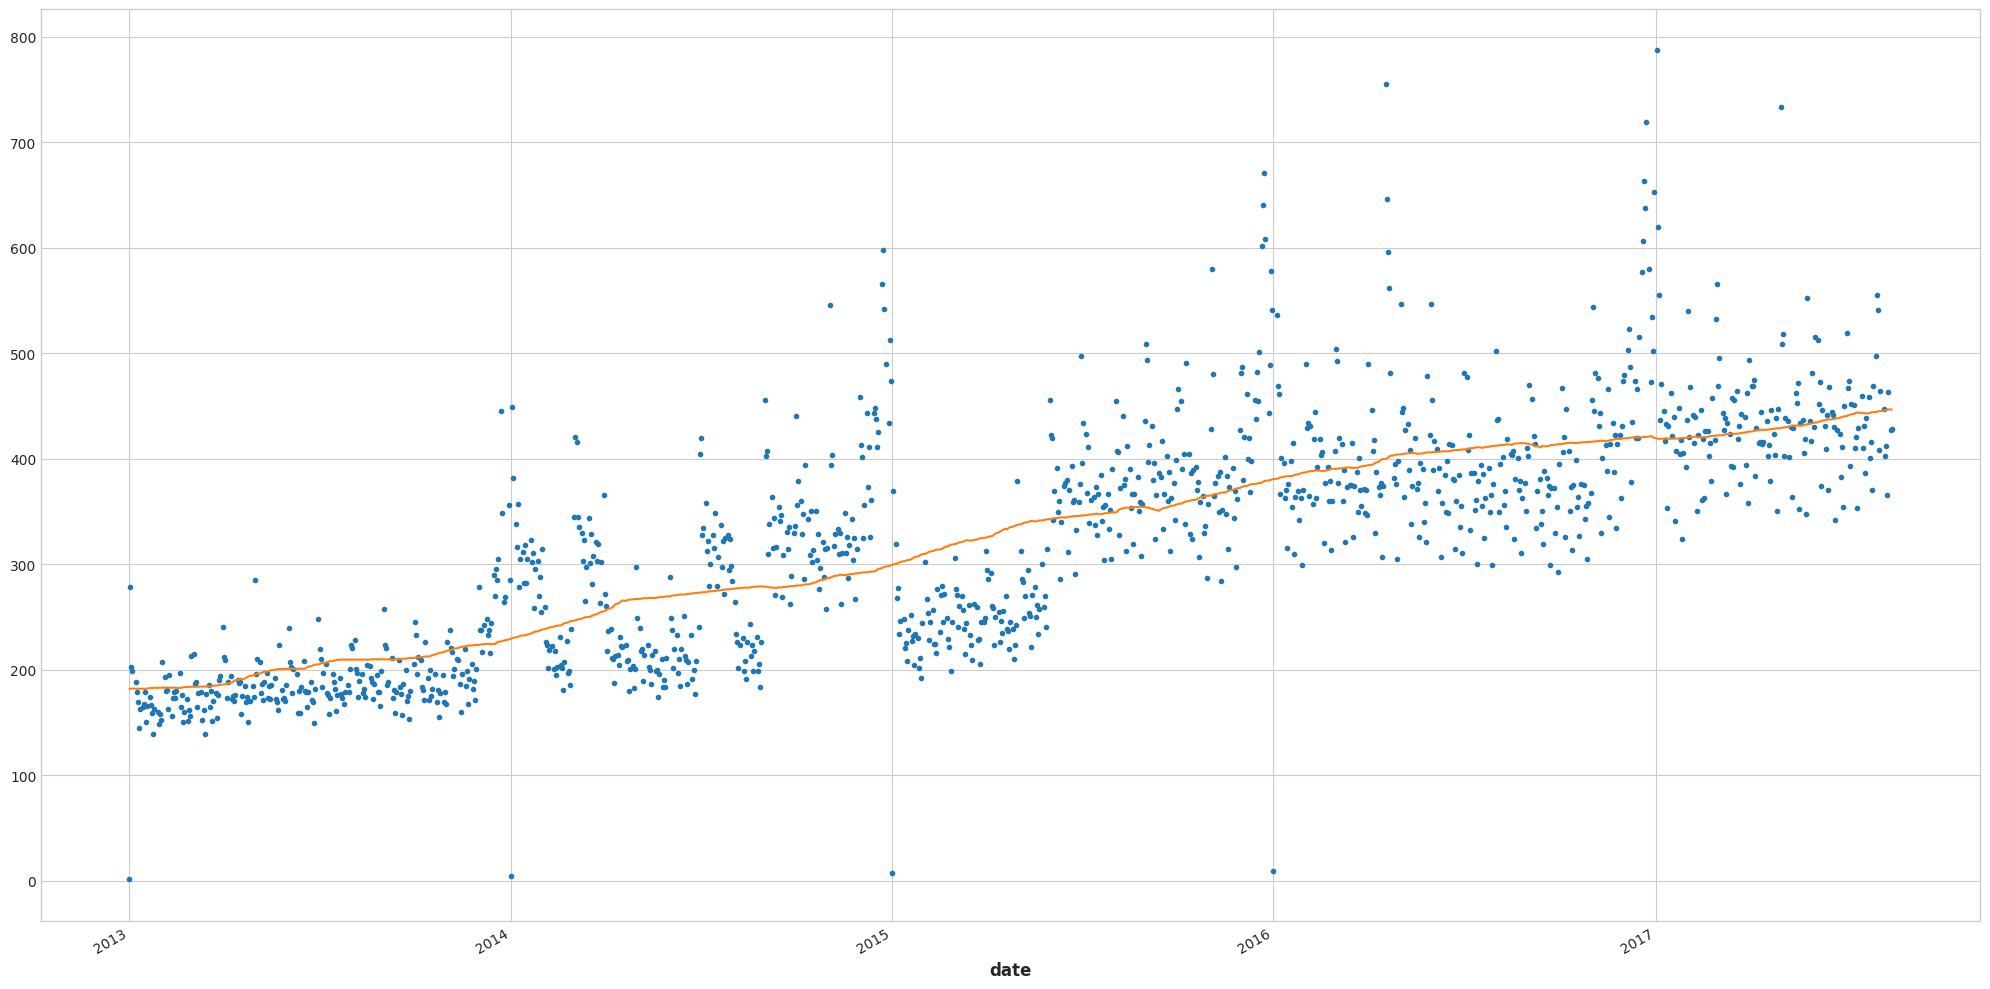

In [12]:
average_sales = df_final[['date', 'sales']].groupby('date').mean()['sales']
average_sales

avg_train = average_sales.copy()
moving_avg = avg_train.rolling(window=365, center = True, min_periods=183).mean()

average_sales.plot(style = '.', figsize=(20, 10))
moving_avg.plot()

Creamos una Serie de tiempo que contiene la fecha ('date') y la media de las ventas ('sales') agrupadas por fecha. Se calcula la media de las ventas para cada fecha. Esto nos da una idea de cómo las ventas promedio varían a lo largo del tiempo.

moving_avg: Es una media móvil de 365 días ('moving_avg') a partir de la Serie de tiempo 'avg_train'. Para calcular la media móvil con una ventana de 365 días. Colocamos el valor promedio se coloca en el centro de la ventana. Tambien especificamos que se requiere un mínimo de 183 observaciones no nulas para calcular la media móvil. Esto ayuda a suavizar los datos y resaltar tendencias a largo plazo.

Al plotear nuestra serie de tiempo vemos que se los datos sigue un patron lineal, las ventas tienen una tendencia al alza, lo que significa que tienden a aumentar con el tiempo. No hay grandes fluctuaciones, lo que significa que no hay un gran riesgo al hacer predicciones; tiende a haber pequeños cambios de un período a otro. Este gráfico de media móvil nos ayuda a identificar patrones a largo plazo relacionados con la estacionalidad. Aunque no es del todo claro, un gráfico de ventas por mes nos ayudará a visualizar los patrones de manera más sencilla.


The sales have an upward trend, meaning it tends to grow over time, there's no big fluctuations meaning there's no big risk when making predictions, it tends to have small changes from period to period. This moving average plot helps us identify long term patterns for seasonality, it's not really clear but a plot of sales by month will help us visualize patterns easily.

### Get the total transactions per month each year

Para poder comprender los datos proponemos separar los datos en año y mes, así desglozaremos la información de una forma más comprensible.

In [13]:
transactions = df_transactions.copy()
transactions['year'] = transactions.date.dt.year
transactions['month'] = transactions.date.dt.month

px.box(transactions, x = 'year', y = 'transactions', color = 'month')

Utilizamos graficos de cajas para visualizar la distribución estadística de nuestro conjunto de datos, incluyendo medidas como la mediana, los cuartiles y los valores atípicos de las transacciones a lo largo de los años y cómo se distribuyen por mes.

Al analizar los datos, podemos identificar una similitud notable en el comportamiento de cada mes a lo largo de varios años. Esta repetición de patrones a lo largo del tiempo sugiere que existen eventos específicos que ocurren anualmente y que influyen en el comportamiento de las ventas. La grafica muestra que los mes 12 (diciembre) los valores atípicos tienden a aumentar significativamente. Esto podría indicar que las festividades navideñas y las compras relacionadas con la temporada navideña tienen un impacto significativo en las ventas.

Surge la posibilidad de que los datos de 'df_holiday' puedan proporcionar información valiosa para comprender mejor cómo estos eventos recurrentes se relacionan con el comportamiento de las ventas a lo largo del tiempo. El análisis de esta relación nos ayuda a tomar decisiones más informadas en la gestión de inventario y estrategias de ventas.

We can see some similarity in each month over the years, we can interpret this as patterns over the years. Meaning there are certain events that repeat annually, giving as an idea that we can work with the data from df_holiday to find relationship between this events and the sales behaviour.

### Find correlation between variables analyzed before

## Get dummy vectors for holiday description


Las variables dummy se utilizan para representar información categórica en forma de variables binarias (0 o 1) que pueden ser utilizadas en análisis estadísticos y modelos de machine learning. En este caso, se está creando una variable ficticia para cada valor único en la columna 'type', lo que significa que cada tipo de día festivo se convierte en una variable binaria separada.




In [14]:
df_holiday1 = pd.get_dummies(df_holiday, columns=['type'], prefix="dmy", dtype = 'int')
df_holiday1.drop(['description', 'locale', 'locale_name'], axis = 1, inplace = True)
df_holiday1

,date,transferred,dmy_Additional,dmy_Bridge,dmy_Event,dmy_Holiday,dmy_Transfer,dmy_Work Day
0,2012-03-02,False,0,0,0,1,0,0
1,2012-04-01,False,0,0,0,1,0,0
2,2012-04-12,False,0,0,0,1,0,0
3,2012-04-14,False,0,0,0,1,0,0
4,2012-04-21,False,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
345,2017-12-22,False,1,0,0,0,0,0
346,2017-12-23,False,1,0,0,0,0,0
347,2017-12-24,False,1,0,0,0,0,0
348,2017-12-25,False,0,0,0,1,0,0


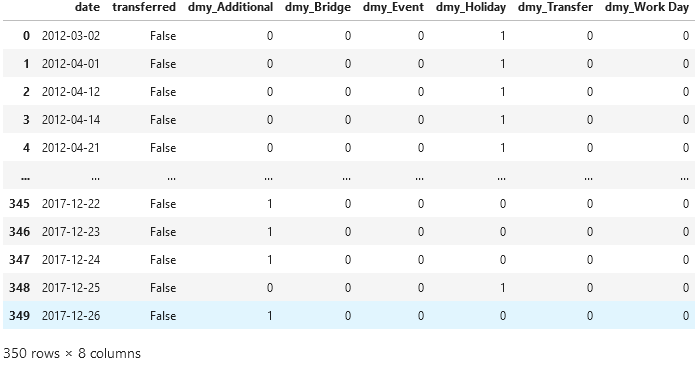

Al crear nuestras variables dummys, optamos por eliminar las columnas que ya no son necesarias como description, locale y locale_name, el resultado final es el DataFrame 'df_holiday1', que contiene las variables dummy representando los diferentes tipos de días festivos. Las variables dummy se usaran para incluir información categórica en análisis posteriores o modelos de machine learning.

### Get dummy vectors for train family

### Merge train dummies and holiday dummies

Aplicaremos la mis operaciones para preparar el data frame de df_train buscando generar características (features) para el análisis de series temporales.

In [15]:
usecols=['store_nbr', 'family', 'date', 'sales']

df1 = df_train[usecols]


df1['date'] = df1.date.dt.to_period('D')
df1 = df1.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    df1
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)


Las columnas que hemos seleccionado cuidadosamente para nuestro análisis son 'store_nbr', 'family', 'date' y 'sales'. Esta selección es fundamental ya que nos permite limitar nuestro conjunto de datos a las columnas que son realmente relevantes para nuestra investigación.

Dado que estamos abordando un análisis de series de tiempo, hemos tomado la medida de transformar la columna "date" para que sea más adecuada para este propósito. Al hacerlo, hemos convertido las fechas en objetos de tipo período ('datetime64[ns]'), lo que facilita trabajar con series temporales y establecer una frecuencia diaria para nuestros datos.

Además de esta transformación, hemos dado un paso más allá en la organización de nuestro DataFrame. Hemos establecido un índice múltiple en el nuevo DataFrame llamado "df1", utilizando las columnas 'store_nbr', 'family' y 'date'. Esta estructura de índice múltiple nos permite identificar y organizar los datos de manera más precisa y detallada, lo que es esencial para nuestro análisis de series temporales.

Una parte fundamental de nuestro análisis implica calcular el promedio de ventas para el año 2017. Para lograrlo, hemos creado la variable "average_sales", que es una serie de Pandas diseñada para contener este promedio. Utilizando el DataFrame "df1", hemos calculado el promedio de ventas para cada fecha y, luego, hemos seleccionado específicamente los datos correspondientes al año 2017. Esto nos proporciona una medida clave que será fundamental en nuestros análisis y pronósticos futuros.

In [16]:
y = average_sales.copy()



fourier = CalendarFourier("W",12)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)"
date,,,,,,,,
2017-01-01,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-01-02,1.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000
2017-01-03,1.000,3.000,0.000,1.000,0.000,0.000,0.000,0.000
2017-01-04,1.000,4.000,0.000,0.000,1.000,0.000,0.000,0.000
2017-01-05,1.000,5.000,0.000,0.000,0.000,1.000,0.000,0.000
...,...,...,...,...,...,...,...,...
2017-08-11,1.000,223.000,0.000,0.000,0.000,0.000,1.000,0.000
2017-08-12,1.000,224.000,0.000,0.000,0.000,0.000,0.000,1.000
2017-08-13,1.000,225.000,0.000,0.000,0.000,0.000,0.000,0.000


La idea es generar características determinísticas para capturar patrones estacionales por ello utilizanmos una expansión de Fourier.
Nuetro proceso deterministico llamdo "dp" tendra las siguientes condiciones:
  - Index de "average_sales",
  - Componecia de tendecia lineal.
  - Sera estacional.
  - Estacionalidad.
  - Son multicolinealidad.

"dp" se utilizarán en el modelado de series temporales para representar patrones estacionales y tendencias en los datos de ventas.


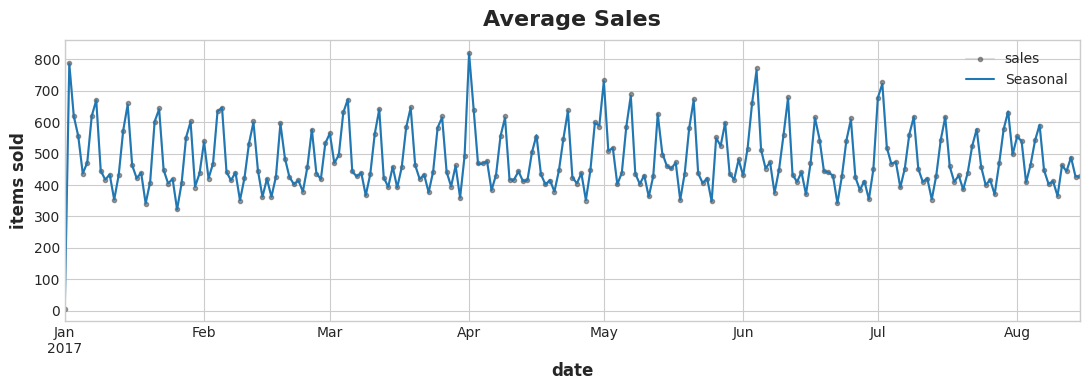

In [17]:
model = XGBRegressor().fit(X, y)


y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Entrenamos un modelo de regresión XGBoost (extreme gradient boosting) para predecir las ventas promedio utilizando las características determinísticas previamente generadas. Primero, se ajusta el modelo a los datos de entrenamiento ('X' y 'y'). Luego, se generan predicciones ('y_pred') basadas en el modelo entrenado.

Nuestra gráfica que muestra tanto las ventas reales y ventras predichas. Las ventas reales ('y') se representan en el eje vertical, y las predicciones del modelo se superponen en el mismo gráfico. Esta visualización permite comparar cómo se ajustan las predicciones del modelo a los datos reales de ventas promedio, mostrando como la predicción alcanza las referencia de ventas promedio.



In [18]:
holidays_events['date'] = holidays_events.index

In [19]:
# The holidays_events file has a category for Holiday and Transfer, as well as a transferred column.
# Since we want the day in which the holiday was celebrated, we'll get this info by comparing the date for both categories.
holiday = pd.DataFrame()
h = holidays_events[(holidays_events.type == 'Holiday') & (holidays_events.transferred == True)]
t = holidays_events[(holidays_events.type == 'Transfer')]
holiday = h.drop('transferred', axis = 1).reset_index(drop = True)
holiday['date'] = t.date.reset_index(drop = True)
holidays_events = holidays_events[(holidays_events.transferred == False) & (holidays_events.type != 'Transfer')].drop('transferred', axis = 1)
holidays_events

,type,locale,locale_name,description,date
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,2012-03-02
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,2012-04-01
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,2012-04-12
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,2012-04-14
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,2012-04-21
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,2017-12-22
2017-12-23,Additional,National,Ecuador,Navidad-2,2017-12-23
2017-12-24,Additional,National,Ecuador,Navidad-1,2017-12-24


Procesamos el DataFrame 'holidays_events' para obtener información sobre las fechas de celebración de días festivos. Primero, creamos una columna 'date' a partir del índice del DataFrame. Luego, se identifican y separan los días festivos transferidos de los días festivos regulares. Los días festivos transferidos se almacenan en un nuevo DataFrame llamado 'holiday', donde se eliminan las columnas no necesarias y se copian las fechas de los días festivos transferidos.

El DataFrame original 'holidays_events' se actualiza para eliminar los registros de días festivos transferidos y los días festivos de tipo 'Transfer'. Esto nos ayuda a organizar la información de manera que solo se conserven los días festivos reales y las fechas en las que se celebraron, facilitando su posterior análisis.

In [20]:
# Group Additional and Bridge type of Holiday as Holiday, since we won't make a distinction for this types of holiday
pd.concat([holidays_events, holiday], ignore_index = True)
holidays_events.type = np.where(holidays_events.type == 'Additional', 'Holiday', holidays_events.type)
holidays_events.type = np.where(holidays_events.type == 'Bridge', 'Holiday', holidays_events.type)
holidays_events

,type,locale,locale_name,description,date
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,2012-03-02
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,2012-04-01
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,2012-04-12
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,2012-04-14
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,2012-04-21
...,...,...,...,...,...
2017-12-22,Holiday,National,Ecuador,Navidad-3,2017-12-22
2017-12-23,Holiday,National,Ecuador,Navidad-2,2017-12-23
2017-12-24,Holiday,National,Ecuador,Navidad-1,2017-12-24


Estandarizanmos las categorías de los días festivos en el DataFrame 'holidays_events'. Concatenamo los registros de días festivos transferidos ('holiday') de nuevo al DataFrame principal. Luego, se reasignan categorías específicas ('Additional' y 'Bridge') a la etiqueta 'Holiday' en la columna 'type'. Esto ayuda a unificar la clasificación de todos los días festivos bajo la misma categoría 'Holiday' para facilitar su organización.

In [21]:
holidays_e = (holidays_events[['date', 'type']])
holidays_e = pd.get_dummies(holidays_e, columns = ['type'], prefix="is", dtype = 'int')
holidays_e.drop('date', axis = 1)

,is_Event,is_Holiday,is_Work Day
date,,,
2012-03-02,0,1,0
2012-04-01,0,1,0
2012-04-12,0,1,0
2012-04-14,0,1,0
2012-04-21,0,1,0
...,...,...,...
2017-12-22,0,1,0
2017-12-23,0,1,0
2017-12-24,0,1,0


In [22]:
X_2 = X.join(holidays_e, on='date', how = 'left').fillna(0.0)
X_2 = X_2.sort_index()
X_2 = X_2[~X_2.index.duplicated(keep='first')]
X_2

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",date,is_Event,is_Holiday,is_Work Day
date,,,,,,,,,,,,
2017-01-01,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,2017-01-01,0.000,0.000,0.000
2017-01-02,1.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,2017-01-02,0.000,0.000,0.000
2017-01-03,1.000,3.000,0.000,1.000,0.000,0.000,0.000,0.000,2017-01-03,0.000,0.000,0.000
2017-01-04,1.000,4.000,0.000,0.000,1.000,0.000,0.000,0.000,2017-01-04,0.000,0.000,0.000
2017-01-05,1.000,5.000,0.000,0.000,0.000,1.000,0.000,0.000,2017-01-05,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.000,223.000,0.000,0.000,0.000,0.000,1.000,0.000,2017-08-11,0.000,0.000,0.000
2017-08-12,1.000,224.000,0.000,0.000,0.000,0.000,0.000,1.000,2017-08-12,0.000,0.000,0.000
2017-08-13,1.000,225.000,0.000,0.000,0.000,0.000,0.000,0.000,2017-08-13,0.000,0.000,0.000


In [23]:
X_2 = X_2.drop('date', axis = 1)
X_2

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",is_Event,is_Holiday,is_Work Day
date,,,,,,,,,,,
2017-01-01,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-01-02,1.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-01-03,1.000,3.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-01-04,1.000,4.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-01-05,1.000,5.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.000,223.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
2017-08-12,1.000,224.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
2017-08-13,1.000,225.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Para facilitar nuestro analisis debemos reducir las variables categoricas, por ello seleccionamos las columnas 'date' y 'type' del DataFrame 'holidays_events' y se aplicamos técnicas de codificación one-hot a la columna 'type' para convertir las categorías de días festivos en características binarias. Luego, fusionan 'X' con 'holidays_e' utilizando la columna 'date' como clave de unión, asegurándose de mantener todas las fechas en 'X'. Se realizan operaciones adicionales para eliminar duplicados, organizar el índice y finalmente, se elimina la columna 'date'. Esto resulta en un conjunto de características 'X_2' listo para su uso en análisis y modelado, que incluye información sobre la presencia o ausencia de días festivos.


In [24]:
stores_sales = pd.read_csv(
    DIR / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
stores_sales['date'] = stores_sales.date.dt.to_period('D')
stores_sales = stores_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    stores_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

y_2 = stores_sales.unstack(['store_nbr', 'family']).loc['2017':'2017-08-15']
y_2

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01      0.000     0.000  0.000     0.000 0.000        0.000   
2017-01-02      5.000     0.000  0.000  1434.000 0.000      166.819   
2017-01-03      4.000     0.000  4.000  3081.000 2.000      519.348   
2017-01-04      1.000     0.000  4.000  3039.000 2.000      543.251   
2017-01-05      2.000     0.000  3.000  2617.000 0.000      533.480   
...               ...       ...    ...       ...   ...          ...   
2017-08-11      1.000     0.000  1.000  1006.000 0.000      145.607   
2017-08-12      6.000     0.000  3.000  1659.000 0.000      243.220   
2017-08-13      1.000     0.000  1.000   803.000 0.000      136.679   
2017-08-14      1.000     0.000  6.000  2201.000 0.000      346.038   
2017-08-15      4.000     0.000  4.000  1942.000 0.000      329.541   

                                                  ...                    \
store_nbr                                         ...         9           
family     CELEBRATION CLEANING    DAIRY    DELI  ... MAGAZINES   MEATS   
date                                              ...                     
2017-01-01       0.000    0.000    0.000   0.000  ...     0.000   0.000   
2017-01-02       0.000  332.000  376.000  44.980  ...     5.000 659.570   
2017-01-03      15.000  952.000 1045.000 209.300  ...     2.000 547.364   
2017-01-04      17.000 1055.000 1029.000 135.944  ...     3.000 395.288   
2017-01-05      40.000  918.000  853.000 137.006  ...     2.000 470.768   
...                ...      ...      ...     ...  ...       ...     ...   
2017-08-11       4.000  341.000  343.000  64.302  ...     5.000 309.245   
2017-08-12       3.000  351.000  526.000  99.488  ...     2.000 260.298   
2017-08-13       1.000  169.000  266.000  47.770  ...     3.000 327.206   
2017-08-14       4.000  571.000  699.000 154.578  ...    12.000 330.975   
2017-08-15      21.000  703.000  602.000 116.402  ...    11.000 449.228   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-01-01         0.000        0.000                   0.000   0.000   
2017-01-02      1243.000       11.000                  41.000 843.596   
2017-01-03       876.000        6.000                  15.000 714.660   
2017-01-04       677.000        6.000                  13.000 536.830   
2017-01-05       604.000        7.000                  10.000 414.100   
...                  ...          ...                     ...     ...   
2017-08-11       373.000       11.000                   2.000 525.224   
2017-08-12       400.000        7.000                  10.000 383.387   
2017-08-13       510.000        2.000                   9.000 412.458   
2017-08-14       445.000        2.000                  14.000 283.429   
2017-08-15       522.000        6.000                   6.000 438.133   

                                                                       
store_nbr                                                              
family     PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                   
2017-01-01          0.000    0.000                      0.000   0.000  
2017-01-02        115.189 3136.896                      1.000  23.000  
2017-01-03        133.039 3229.558                      1.000  14.000  
2017-01-04         75.201 1491.417                      7.000   0.000  
2017-01-05        113.699 1566.821                      1.000  17.000  
...                   ...      ...                        ...     ...  
2017-08-

Optimizamos el tipo de datos y se convierten las fechas en objetos 'period'(tipo de dato que se utiliza para representar intervalos de tiempo regulares). Luego, organizamos el DataFrame con un índice múltiple y se calculan las ventas promedio agrupadas por fecha para el año 2017. Generammos 'y_2' que muestra las ventas desglosadas por tienda y familia de productos desde el inicio de 2017 hasta el 15 de agosto de 2017.


In [25]:
fourier_2 = CalendarFourier(freq='W', order=12)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier_2],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)
X['Weekend'] = (X.index.dayofweek > 4)
X['PayDays'] = (X.index.day == 15) | (X.index.to_timestamp().is_month_end)

X = X.join(holidays_e, on='date', how = 'left').fillna(0)
X = X.drop('date', axis = 1)
X = X.sort_index()
X = X[~X.index.duplicated(keep='first')]
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",NewYear,Weekend,PayDays,is_Event,is_Holiday,is_Work Day
date,,,,,,,,,,,,,,
2017-01-01,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,True,True,False,0.000,0.000,0.000
2017-01-02,1.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,False,False,False,0.000,0.000,0.000
2017-01-03,1.000,3.000,0.000,1.000,0.000,0.000,0.000,0.000,False,False,False,0.000,0.000,0.000
2017-01-04,1.000,4.000,0.000,0.000,1.000,0.000,0.000,0.000,False,False,False,0.000,0.000,0.000
2017-01-05,1.000,5.000,0.000,0.000,0.000,1.000,0.000,0.000,False,False,False,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.000,223.000,0.000,0.000,0.000,0.000,1.000,0.000,False,False,False,0.000,0.000,0.000
2017-08-12,1.000,224.000,0.000,0.000,0.000,0.000,0.000,1.000,False,True,False,0.000,0.000,0.000
2017-08-13,1.000,225.000,0.000,0.000,0.000,0.000,0.000,0.000,False,True,False,0.000,0.000,0.000


Generamos características temporales y marcadores en el conjunto de datos 'X'. Se utiliza 'CalendarFourier' para crear componentes estacionales (patrones y variaciones de los datos a lo largo del tiempo) basados en una frecuencia semanal y se agrega un proceso determinístico que incluye constantes, términos estacionales y otros marcadores, como el inicio de año, fines de semana y días de pago. Luego, combinamos 'X' con datos de días festivos y se llenan los valores faltantes con ceros. Finalmente, se realiza la limpieza de datos, eliminando duplicados, organizando el índice y eliminando la columna de fechas. Esto resulta en un conjunto de características 'X' que captura patrones temporales y eventos importantes para análisis y modelado.

In [26]:
X['NewYear'] = X['NewYear'].astype('float64')
X['Weekend'] = X['Weekend'].astype('float64')
X['PayDays'] = X['PayDays'].astype('float64')
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",NewYear,Weekend,PayDays,is_Event,is_Holiday,is_Work Day
date,,,,,,,,,,,,,,
2017-01-01,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000
2017-01-02,1.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-01-03,1.000,3.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-01-04,1.000,4.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-01-05,1.000,5.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.000,223.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2017-08-12,1.000,224.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000
2017-08-13,1.000,225.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000


Ya con los datos preparados podemos usar un modelo de regresión por arboles, buscamos predecir las ventas de un producto especifico en la tienda correspondiente.

## Dividimos los datos de entrenamiento.

In [27]:
model = RandomForestRegressor()

y_train, y_valid = y_2[:"2017-07-01"], y_2["2017-07-02":]
X_train, X_valid = X[: "2017-07-01"], X["2017-07-02" :]


model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_2.columns)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_2.columns)


## Métricas del error.



In [28]:
error_train = mean_squared_log_error(y_fit, y_2[:"2017-07-01"])
error_train = np.sqrt(error_train)

error_valid = mean_squared_log_error(y_pred, y_2["2017-07-02":])
error_valid = np.sqrt(error_valid)
error_valid

print("Error de train: ",error_train)
print("Error de validation: ",error_valid)

Error de train:  0.3725941448363977
Error de validation:  0.5098903788216825


## Ajuste de hiperparámetros y regularización

In [29]:
from sklearn.model_selection import GridSearchCV,\
RandomizedSearchCV

param_grid = {
    'n_estimators': [150, 200, 250, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 6, 9, 12, 15],
    'max_leaf_nodes': [3, 6, 9, 12, 15],
}


#grid_search = GridSearchCV(RandomForestRegressor(),
                           #param_grid=param_grid)
#grid_search.fit(X, y_2)
#print(grid_search.best_estimator_)

Para el ajuste de los hiperparámetros utilizamos GridSearchCV. En param_grid lo primero que hacemos es definir un conjunto de hiperparámetros que deseamos optimizar, como son n_estimators, max_features, max_depth, y mas_leaf_nodes.
Posteriormente se ajusta el modelo para buscar la mejor combinación de parámetros.

Para la parte de regularización, nosotros decidimos utilizar un modelo de random forest, ya que el modelo de XGBoost estaba haciendo overfitting en los datos de entrenamiento. Random forest funciona de una manera un poco diferente, ya que lo que nosotros podíamos modificar son los parámetros que buscamos optimizar, la forma en la que nosotros buscamos evitar el overfitting fue ajustando estos mismos hiperparámetros para evitar una complejidad muy alta en su arquitectura.


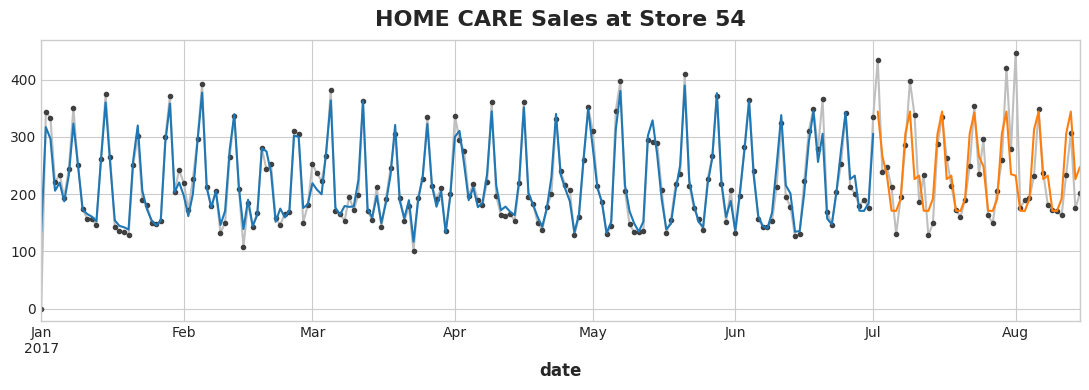

In [30]:
STORE_NBR = '54'  # 1 - 54
FAMILY = 'HOME CARE'

ax = y_2.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_fit.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

 El modelo de random forest regressor se entrena y se utilizan las predicciones para una tienda y una familia de productos seleccionadas. Luego, se visualizan las ventas reales y las predicciones en un gráfico para evaluar el rendimiento del modelo. Vemos que las predicciones del modelo en su mayoria alcanza las referencia de ventas reales.

In [31]:
df_test = pd.read_csv(
    DIR / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)

X_test.index.name = 'date'

X_test['NewYear'] = (X_test.index.dayofyear == 1)
X_test['Weekend'] = (X_test.index.dayofweek > 4)
X_test['PayDays'] = (X_test.index.day == 15)

X_test = X_test.join(holidays_e, on='date').fillna(0.0)
X_test = X_test.drop('date', axis = 1)
X_test = X_test.sort_index()
X_test = X_test[~X_test.index.duplicated(keep='first')]
X_test



y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y_2.columns)
y = y_submit.copy()
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

Preparamos los datos para nuestro modelo, se crean características para este conjunto de prueba utilizando un proceso determinístico previamente definido ('dp'), que incluye marcadores de fechas como Año Nuevo, Fin de Semana y Días de Pago.

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], ordered=False, dtype='category', name='family')

CategoricalIndex(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                  '19', '2', '20', '21', '22', '23', '24', '25', '26', '27',
                  '28', '29', '3', '30', '31', '32', '33', '34', '35', '36',
                  '37', '38', '39', '4', '40', '41', '42', '43', '44', '45',
                  '46', '47', '48', '49', '5', '50', '51', '52', '53', '54',
                  '6', '7', '8', '9'],
                 categories=['1', '10', '11', '12', ..., '6', '7', '8', '9'], ordered=False, dtype='category', name='store_nbr')

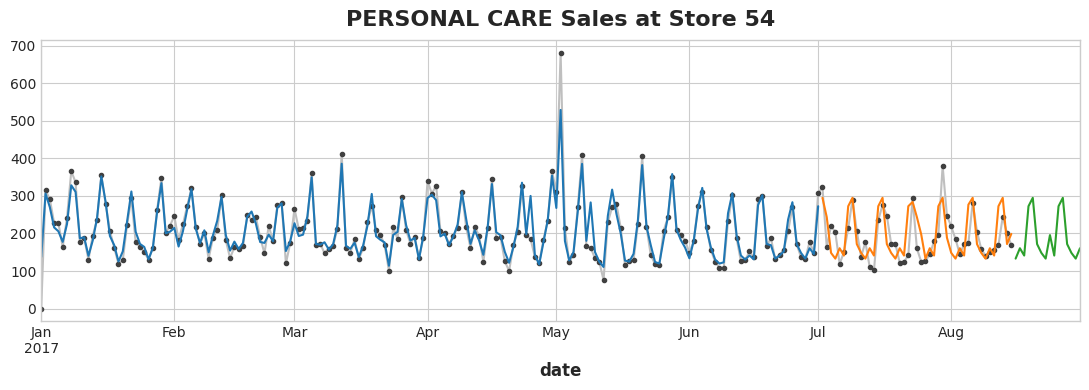

In [32]:
STORE_NBR = '54'  # 1 - 54
FAMILY = 'PERSONAL CARE'
# Uncomment to see a list of product families
display(stores_sales.index.get_level_values('family').unique())

display(df_test.index.get_level_values('store_nbr').unique())
ax = y_2.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_fit.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

Nuestro modelo de regresión entrenado utiliza las características del conjunto de prueba ('X_test') para realizar predicciones de ventas futuras.  Además, realizamos  una comparación visual entre las ventas reales ('y_2') y las predicciones del modelo ('y_pred') para una tienda y una familia de productos específicas.

El modelo de predicción demuestra un excelente desempeño al ajustarse de manera precisa a los valores reales de ventas. Sus predicciones exhiben un margen de error notablemente bajo, lo que indica su capacidad para proporcionar estimaciones confiables y cercanas a la realidad. Esta precisión es fundamental para optimizar para predecir meses futuros.

## Exploración de otros modelos.

Realizamos una clase que busca juntar dos modelos distintos, esto lo hicimos con el fin de poder predecir tanto la estacionalidad de los datos de nuestro modelo, como la serialidad de estos mismos.
Lo que hacemos en esta clase es hacer la predicción el entrenamiento de nuestro primer modelo, que va a recibir los features de la estacionalidad, luego vamos a restar a nuestros datos de entrenamiento las predicciones de este modelo y nos vamos a quedar con un residuo, va a ser el parámetro que vamos a meter a nuestro segundo modelo que va a buscar obtener la serialidad de los datos a través de diferentes lags con algunas variables, como podría ser el petróleo.


In [33]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method



    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )


        # Compute residuals
        y_resid = y - y_fit
        #y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        #y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred


Un factor del cual no hemos hablado ni tomado en cuenta a lo largo de nuestro reporte es que Ecuador es un país que depende totalmente del petróleo, por lo que los valores de estos podrían llegar a ser importantes para la estimación de nuestras ventas.

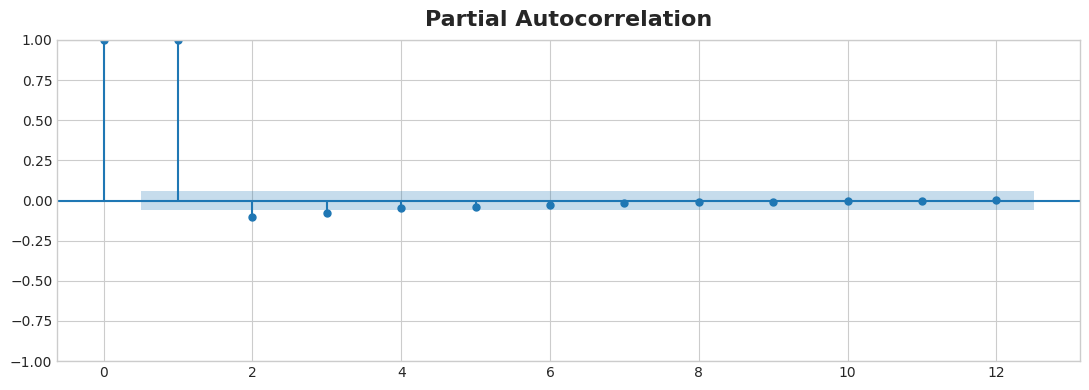

In [34]:

oil_t = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')


oil_t['avg_oil_7'] = oil_t['dcoilwtico'].rolling(7).mean()



trends = pd.DataFrame(index = pd.date_range('2013-01-01','2017-08-31')).to_period('D')
trends = trends.join(oil_t, how='outer')
trends['avg_oil_7'].fillna(method = 'ffill', inplace = True)
trends.dropna(inplace = True)
_ = plot_pacf(trends.avg_oil_7, lags = 12)


En esta gráfica de 'partial autocorrelation' podemos ver los lags que son significativos para nuestro analisis. Podemos notar que los primeros 4 son significativos. 

In [35]:

# Import 
oil_t1= pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil_t1["date"] = pd.to_datetime(oil_t1.date)

oil_t1 = oil_t1.set_index("date").dcoilwtico.resample("D").sum().reset_index()

oil_t1["dcoilwtico"] = np.where(oil_t1["dcoilwtico"] == 0, np.nan, oil_t1["dcoilwtico"])
oil_t1["dcoilwtico_interpolated"] =oil_t1.dcoilwtico.interpolate()

p = oil_t1.melt(id_vars=['date']+list(oil_t1.keys()[5:]), var_name='Legend')
fig = px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

fig.show()


Nos dimos cuenta que a los datos del petróleo le faltan los datos de los fines de semana. Y como el precio del petróleo no cambia tanto de un día a otro, entonces podemos llenar algunos de los espacios vacíos con un método de interpolación lineal.

In [36]:
date_range = pd.date_range(start='2017', end='2017-08-15', freq='D')

df_oil.set_index('date', inplace=True)

df_oil = df_oil.reindex(date_range)
df_oil
df_oil.interpolate(method = 'linear', inplace = True)
df_oil = df_oil.fillna(0)
oil = df_oil['dcoilwtico']
df_oil

,dcoilwtico
2017-01-01,0.000
2017-01-02,0.000
2017-01-03,52.360
2017-01-04,53.260
2017-01-05,53.770
...,...
2017-08-11,48.810
2017-08-12,48.403
2017-08-13,47.997
2017-08-14,47.590


Los features que vamos a ingresar a la segunda parte de nuestro modelo, van a ser los lags de petróleo.

In [37]:
oil = df_oil['dcoilwtico'].to_numpy()

X_1 = X.copy()
fechas = pd.date_range(start='2017',  end = '2017-08-15', freq='D')  # Puedes ajustar la fecha de inicio según sea necesario



X_2 = pd.DataFrame()
X_2.index = fechas
X_2['oil'] = oil[:1684]

X_2['lagoil_1_dcoilwtico'] = X_2['oil'].shift(1)
X_2['lagoil_2_dcoilwtico'] = X_2['oil'].shift(2)
X_2['lagoil_3_dcoilwtico'] = X_2['oil'].shift(3)
X_2['lagoil_4_dcoilwtico'] = X_2['oil'].shift(4)

X_2['oil_week_avg'] = X_2['oil'].rolling(7).mean()

X_2 = X_2.fillna(0)

## Dividimos los valores de train, entre train y validation.

Para hacer una estimación de las predicciones del modelo vamos a dividir los datos de train, entre train y validation.

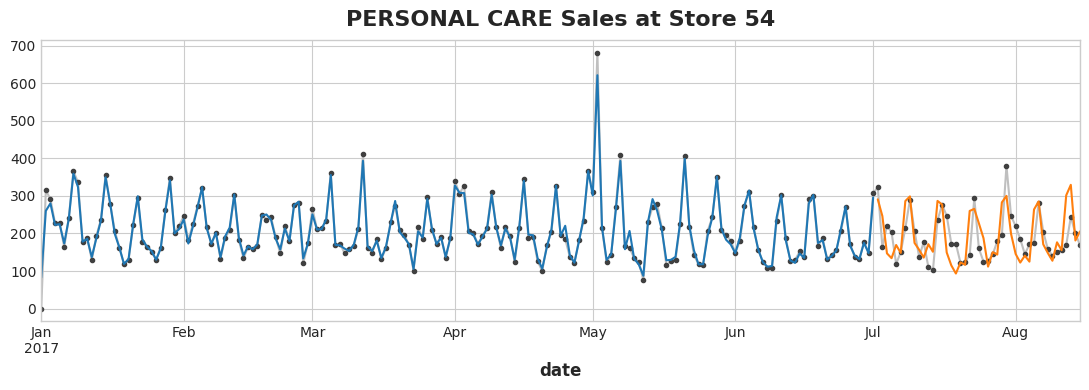

In [38]:
# Create model
model = BoostedHybrid(
    model_1=RandomForestRegressor(),
    model_2=RandomForestRegressor(),
)

y_train, y_valid = y_2[:"2017-07-01"], y_2["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)

y_fit = pd.DataFrame(model.predict(X1_train, X2_train), index=X1_train.index, columns=y_2.columns)
y_pred = pd.DataFrame(model.predict(X1_valid, X2_valid), index=X1_valid.index, columns=y_2.columns)

ax = y_2.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_fit.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)

ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

## Error

In [39]:
error_train = mean_squared_log_error(abs(y_fit), abs(y_2[:"2017-07-01"]))
error_train = np.sqrt(error_train)

error_valid = mean_squared_log_error(abs(y_pred), abs(y_2["2017-07-02":]))
error_valid = np.sqrt(error_valid)
error_valid

print("Error de train: ",error_train)
print("Error de validation: ",error_valid)

Error de train:  0.3145606584780957
Error de validation:  0.5265792842400678


## Ajustamos los features para las pruebas del modelo.

Ahora nada más faltaría ajustar nuestros features a las datos de prueba. Vamos a obtener los features de seasonality, del dataset de test.csv, y también obtendremos los lags del oil para estas fechas.

In [40]:
df_test = pd.read_csv(
    DIR / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)

X_test.index.name = 'date'

X_test['NewYear'] = (X_test.index.dayofyear == 1)
X_test['Weekend'] = (X_test.index.dayofweek > 4)
X_test['PayDays'] = (X_test.index.day == 15)

X_test = X_test.join(holidays_e, on='date').fillna(0.0)
X_test = X_test.drop('date', axis = 1)
X_test = X_test.sort_index()
X_test = X_test[~X_test.index.duplicated(keep='first')]


In [41]:
oil_test = pd.read_csv(DIR / 'oil.csv')
oil_test['date'] = pd.to_datetime(oil_test['date'])
date_range = pd.date_range(start='2017-08-16', end='2017-08-31', freq='D')  # Sustituye 'fecha_inicio' y 'fecha_fin'

# Asegúrate de que 'date' sea el índice en df_oil
oil_test.set_index('date', inplace=True)
# Reindexa el DataFrame con el nuevo rango de fechas
oil_test = oil_test.reindex(date_range)

oil_test.interpolate(method = 'linear', inplace = True)
oil_test = oil_test.fillna(0)
oil_test

,dcoilwtico
2017-08-16,46.800
2017-08-17,47.070
2017-08-18,48.590
2017-08-19,48.190
2017-08-20,47.790
2017-08-21,47.390
2017-08-22,47.650
2017-08-23,48.450
2017-08-24,47.240
2017-08-25,47.650


In [42]:
oil = df_oil['dcoilwtico'].to_numpy()
oil
X_2 = pd.DataFrame()



X_2['oil'] = oil_test

X_2['lagoil_1_dcoilwtico'] = X_2['oil'].shift(1)
X_2['lagoil_2_dcoilwtico'] = X_2['oil'].shift(2)
X_2['lagoil_3_dcoilwtico'] = X_2['oil'].shift(3)
X_2['lagoil_4_dcoilwtico'] = X_2['oil'].shift(4)

X_2['oil_week_avg'] = X_2['oil'].rolling(7).mean()


X_2 = X_2.fillna(0)

## Hacemos las pruebas con el modelo

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], ordered=False, dtype='category', name='family')

CategoricalIndex(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                  '19', '2', '20', '21', '22', '23', '24', '25', '26', '27',
                  '28', '29', '3', '30', '31', '32', '33', '34', '35', '36',
                  '37', '38', '39', '4', '40', '41', '42', '43', '44', '45',
                  '46', '47', '48', '49', '5', '50', '51', '52', '53', '54',
                  '6', '7', '8', '9'],
                 categories=['1', '10', '11', '12', ..., '6', '7', '8', '9'], ordered=False, dtype='category', name='store_nbr')

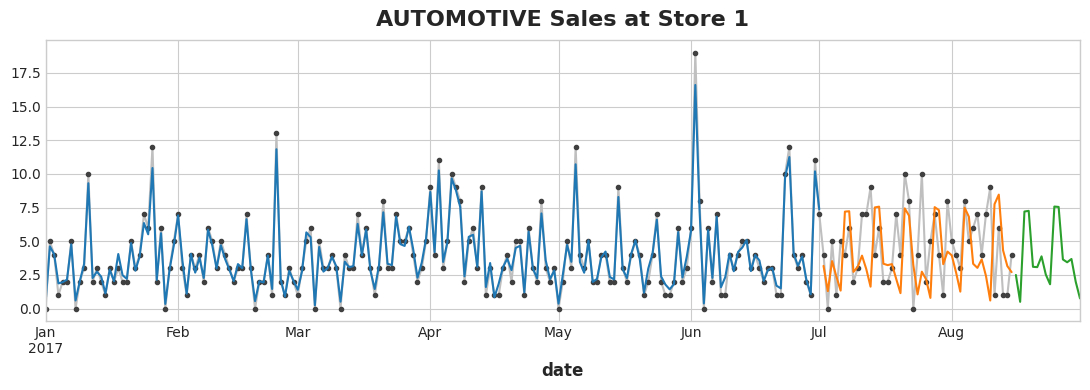

In [43]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'AUTOMOTIVE'
y_fore = model.predict(X_test, X_2)

display(stores_sales.index.get_level_values('family').unique())

display(df_test.index.get_level_values('store_nbr').unique())
ax = y_2.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_fit.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax = y_fore.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

Aqui podemos ver los resultados del fit, validation, y las predicciones para los datos de 'test', podemos ver que en su mayoría los datos se acercan a sus referencias, sin embargo podemos darnos cuenta que nuestro modelo no está haciendo overfitting.

In [44]:
y_submit = pd.DataFrame(model.predict(X_test, X_2), index=X_test.index, columns=y_2.columns)
y_submit['sales'] = y_submit['sales'].applymap(lambda x: max(x, 0))
y = y_submit.copy()
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)


## Conclusión

Al evaluar nuestros scores con los diferentes modelos que probamos en la plataforma de kaggle, notamos que nuestra mejor puntuación de 0.4501 con el modelo en el que utilizamos Random Forest para predecir la estacionalidad de nuestros datos, en comparación de la puntuación de 0.459 que obtuvimos con nuestro modelo híbrido. Entonces no siempre un modelo mas complejo va a ser mejor para predecir datos. También nos dimos cuenta de la importancia de procesar y escoger bien los datos para tener buenos features para nuestros modelos.